In [1065]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

0. Set Hyperparamters

In [1224]:
train_ratio = 0.8
validation_ratio = 0.2
epochs = 1000
batch_size = 1024

1. Import Data

In [1236]:
# 1. Import data
NY_data = pd.read_csv("data/NY_data.csv")

# 2. Split data into x and y values
y = NY_data['price']
X = NY_data.drop(columns=['price'])

# 3. Split data into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

# 4. Normalize data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_norm = X_scaler.fit_transform(X_train)
X_val_norm = X_scaler.transform(X_val)
X_test_norm = X_scaler.transform(X_test)

y_train_norm = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

In [1237]:
DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

DNN.compile(loss='mse', optimizer='adam')

2. Model Initilization

In [1238]:
history = DNN.fit(X_train_norm, y_train_norm, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val_norm, y_val_norm), callbacks=[early_stop])

Epoch 1/1000
32/32 [==============================] - 1s 18ms/step - loss: 3.8318 - val_loss: 3.2011
Epoch 2/1000
32/32 [==============================] - 0s 15ms/step - loss: 3.0562 - val_loss: 2.9795
Epoch 3/1000
32/32 [==============================] - 0s 15ms/step - loss: 2.8121 - val_loss: 2.7758
Epoch 4/1000
32/32 [==============================] - 1s 16ms/step - loss: 2.5936 - val_loss: 2.5341
Epoch 5/1000
32/32 [==============================] - 0s 15ms/step - loss: 2.4247 - val_loss: 2.3781
Epoch 6/1000
32/32 [==============================] - 0s 15ms/step - loss: 2.2397 - val_loss: 2.1794
Epoch 7/1000
32/32 [==============================] - 0s 15ms/step - loss: 2.0918 - val_loss: 2.0551
Epoch 8/1000
32/32 [==============================] - 0s 15ms/step - loss: 2.0190 - val_loss: 1.9531
Epoch 9/1000
32/32 [==============================] - 0s 15ms/step - loss: 1.8432 - val_loss: 1.8484
Epoch 10/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.7780 - val_lo

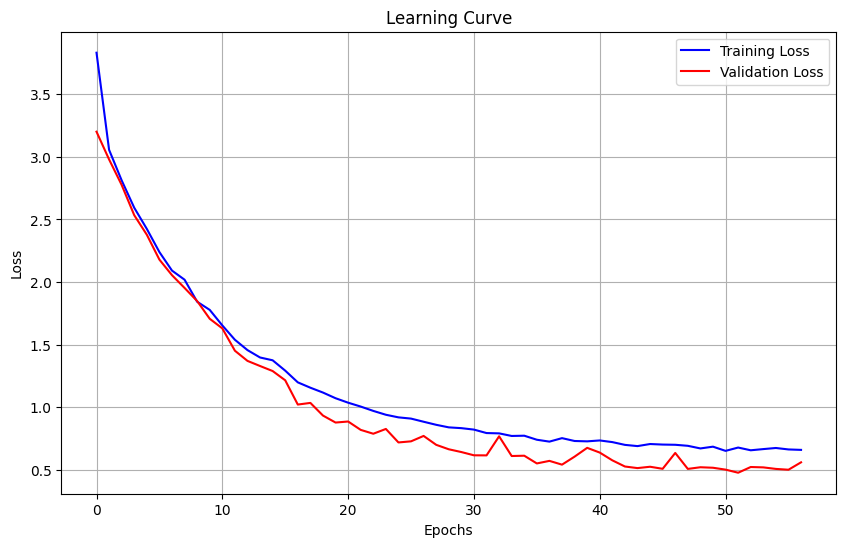

In [1239]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [1240]:
loss = DNN.evaluate(X_test_norm, y_test_norm)
print("Test Loss:", loss)

318/318 [==============================] - 0s 974us/step - loss: 0.5224
Test Loss: 0.5223929286003113


In [1241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = y_scaler.inverse_transform(DNN.predict(X_test_norm))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

318/318 [==============================] - 0s 909us/step
Mean Absolute Error: 345233.0271748165
Mean Squared Error: 1721843095169.8875
Root Mean Squared Error: 1312190.1901667637
R-squared: 0.4396353123076999


In [1248]:
predictions = DNN.predict(X_test_norm)
predictions = y_scaler.inverse_transform(predictions)
print("Expected Prices:", ", ".join(str(expected) for expected in y_test.iloc[:5]))
print("Predicted Prices:", " ".join(str(predicted) for predicted in predictions[:5, 0]))

318/318 [==============================] - 0s 1ms/step
Expected Prices: 119900.0, 449999.0, 549999.0, 449000.0, 250000.0
Predicted Prices: 277786.16 732700.9 734712.1 531304.4 604993.56
